In [1]:
import torch, torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, random_split

import numpy as np
import matplotlib.pyplot as plt

import random
import pandas as pd
import seaborn as sns

In [2]:
train_dataset = datasets.MNIST("dataset", train = True, download = True)
test_dataset = datasets.MNIST("dataset", train = False, download = True)

In [3]:
train_transform = transforms.Compose([ToTensor(), ])
test_transform = transforms.Compose([ToTensor(), ])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

len_data = len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(len_data * 0.8), int(len_data * 0.2)])
batch_size = 256

In [4]:
train_loader = DataLoader(train_data, batch_size = batch_size)
valid_loader = DataLoader(val_data, batch_size = batch_size)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

In [5]:
class Encoder(nn.Module):
    def __init__(self, encoder_dim):
        super().__init__()
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size = 5),
            nn.ReLU(True),
            nn.Conv2d(4, 8, kernel_size = 5),
            nn.ReLU(True)
        )

        #8 * 20 * 20
        self.flatten = nn.Flatten(start_dim = 1)
        self.encoder_fc = nn.Sequential(
            nn.Linear(3200, 128),
            nn.ReLU(True),
            nn.Linear(128, encoder_dim)
        )

    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_fc(x)
        return x

In [6]:
class Decoder(nn.Module):
    def __init__(self, encoder_dim):
        super().__init__()
        
        self.decoder_fc = nn.Sequential(
            nn.Linear(encoder_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3200),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim = 1, unflattened_size = (8, 20, 20))

        self.decoder_cnn = nn.Sequential(
            nn.ConvTranspose2d(8, 10, kernel_size = 5), 
            nn.ConvTranspose2d(10, 1, kernel_size = 5)
        )

    def forward(self, x):
        x = self.decoder_fc(x)
        x = self.unflatten(x)
        x = self.decoder_cnn(x)
        x = torch.sigmoid(x)
        return x

In [7]:
loss_fn = nn.MSELoss()
lr = 0.01

torch.manual_seed(0)

encoder_dim = 4

encoder = Encoder(encoder_dim = encoder_dim)
decoder = Decoder(encoder_dim = encoder_dim)

params_optimize = [
    {'params' : encoder.parameters()},
    {'params' : decoder.parameters()}
]

optim = optim.Adam(params_optimize, lr = lr, weight_decay = 1e-05)

In [8]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Selected device {0}".format(device))

Selected device cpu


In [9]:
encoder.to(device)

Encoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(4, 8, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_fc): Sequential(
    (0): Linear(in_features=3200, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=4, bias=True)
  )
)

In [10]:
decoder.to(device)

Decoder(
  (decoder_fc): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=3200, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(8, 20, 20))
  (decoder_cnn): Sequential(
    (0): ConvTranspose2d(8, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): ConvTranspose2d(10, 1, kernel_size=(5, 5), stride=(1, 1))
  )
)

In [14]:
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    encoder.train()
    decoder.train()
    train_loss = []
    for image_batch, _ in dataloader:
        image_batch = image_batch.to(device)
        encoder_data = encoder(image_batch)
        decoder_data = decoder(encoder_data)
        loss = loss_fn(decoder_data, image_batch)
        print("Batch loss {}".format(loss.data))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.detach().cpu().numpy())
    return np.mean(train_loss)


In [12]:
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            image_batch = image_batch.to(device)
            encoder_data = encoder(image_batch)
            decoder_data = decoder(encoder_data)
            conc_out.append(decoder_data.cpu())
            conc_label.append(image_batch.cpu())
        
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label)
        val_loss = loss_fn(conc_out, conc_label)
    
    return val_loss.data

In [18]:
def plot_ae(encoder, decoder, n = 10):
    plt.figure(figsize = (16, 5))
    targets = test_dataset.targets.numpy()
    t_indx = {i : np.where(targets == i)[0][0] for i in range(n)}
    for i in range(n):
        ax1 = plt.subplot(2, n, i + 1)
        img = test_dataset[t_indx[i]][0].unsqueeze(0).to(device)
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img = decoder(encoder(img))
        plt.imshow(img.cpu().squeeze().numpy(), cmap = 'gray')
        ax1.axis(False)
        if i == n // 2 : 
            ax1.set_title("Original images")
        
        ax2 = plt.subplot(2, n, i + 1 + n)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap = 'gray')
        ax2.axis(False)
        if i == n // 2:
            ax1.set_title("Reconstructered images")
    plt.show()


Epoch 1 train loss = 0.03214285150170326 val loss = 0.03161666542291641


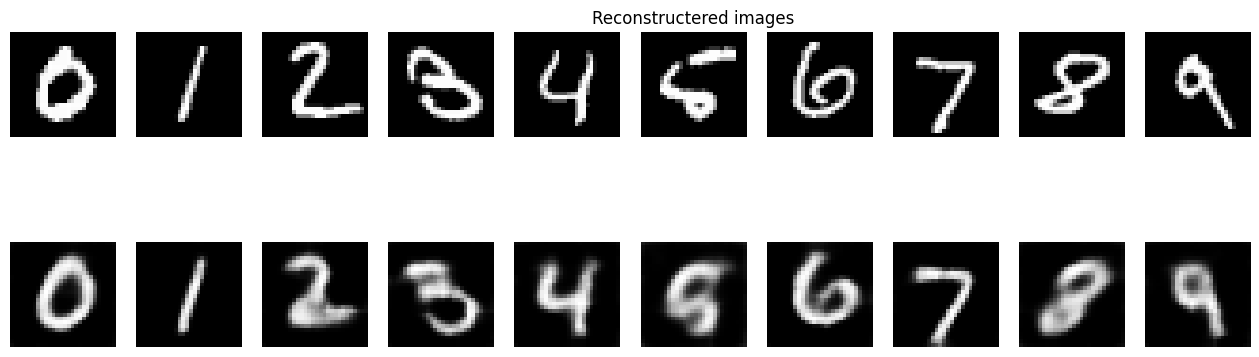

Epoch 2 train loss = 0.03178780898451805 val loss = 0.031678441911935806


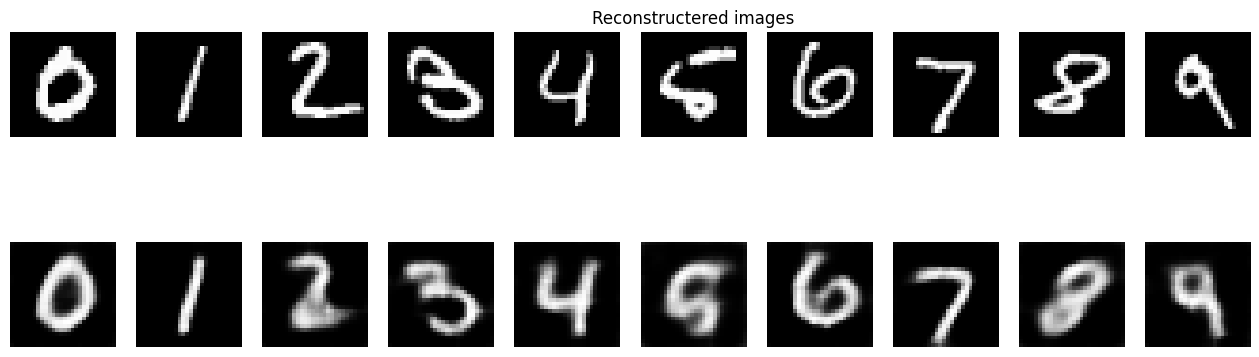

Epoch 3 train loss = 0.03145940601825714 val loss = 0.031559254974126816


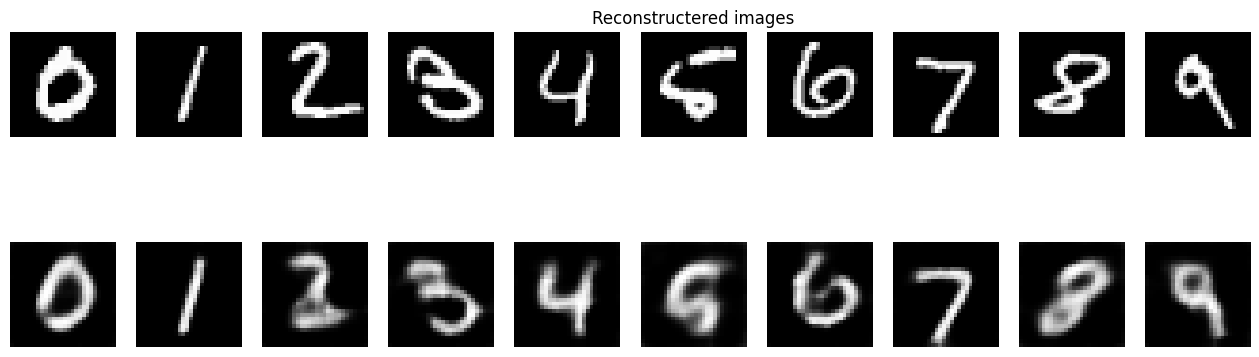

In [19]:
epochs = 3
tlt_loss = { 'train_loss': [], 'val_loss': []}
for i in range(epochs):
    train_loss = train_epoch(encoder, decoder, device, train_loader, loss_fn, optim)
    val_loss = test_epoch(encoder, decoder, device, test_loader, loss_fn)
    tlt_loss['train_loss'].append(train_loss)
    tlt_loss['val_loss'].append(val_loss)
    print("Epoch {0} train loss = {1} val loss = {2}".format(i+1, train_loss, val_loss))
    plot_ae(encoder, decoder, n = 10)

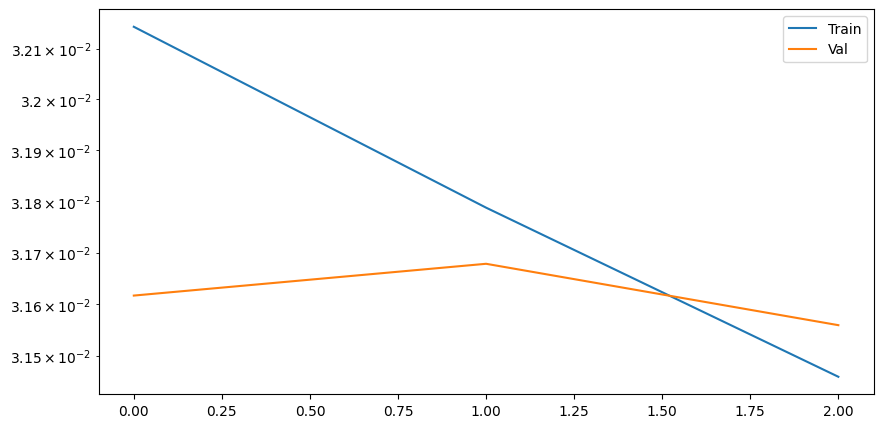

In [21]:
plt.figure(figsize = (10, 5))
plt.semilogy(tlt_loss['train_loss'], label = 'Train')
plt.semilogy(tlt_loss['val_loss'], label = 'Val')
plt.legend()
plt.show()

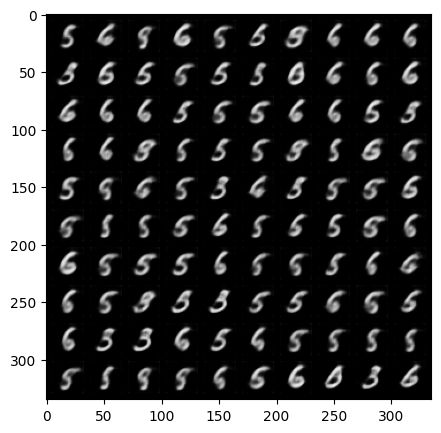

In [25]:
encoder.eval()
decoder.eval()

with torch.no_grad():
    data_iter = iter(test_loader)
    images, labels = data_iter.__next__()

    images = images.to(device)
    hid = encoder(images)
    hid = hid.cpu()

    mean = hid.mean(dim = 0)
    std = (hid - mean).pow(2).mean(dim = 0).sqrt()

    hiddens = torch.rand(128, encoder_dim) * std + mean

    hiddens = hiddens.to(device)
    img_rec = decoder(hiddens)
    img_rec = img_rec.cpu()

    fig, ax = plt.subplots(figsize = (10, 5))
    imgs = torchvision.utils.make_grid(img_rec[:100], 10, 5)
    imgs = imgs.numpy()
    imgs = np.transpose(imgs, (1, 2, 0))
    plt.imshow(imgs)
    plt.show()